In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import pathlib 
import os
import joblib

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller  
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from collections import Counter
from datetime import date 
import datetime


/var/folders/sv/b643fd993ml6d9g_v9klf5mh0000gn/T/ipykernel_49996/3126906956.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
cur_path  = os.getcwd()

devices_df = pd.read_csv(cur_path + '/devices.csv')
readings_df = pd.read_csv(cur_path + '/sampled_readings.csv')
reading_types_df = pd.read_csv(cur_path + '/reading_types.csv')

### Outlier Detection Using IQR

In [3]:
def detect_outliers(df,n,features):
    """
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than n outliers according
    to the Tukey method.
    """
    outlier_indices = []
    
    # iterate over features(columns)
    for col in features:
        # 1st quartile (25%)
        Q1 = np.nanpercentile(df[col], 25)
        # 3rd quartile (75%)
        Q3 = np.nanpercentile(df[col],75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        print("First Quartertile:", Q1, ". Third Quartile: ", Q3, ".Interquartile Range: ", IQR)
        # outlier step
        outlier_step = 1.5 * IQR
        
        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        
        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
        
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v >= n )
    
    return multiple_outliers   

In [4]:
processed_df = readings_df 
for k, v in readings_df.groupby('value_type_id'):
    print(reading_types_df.at[k - 1, 'reading_type_name'],'-'*90)
    outliers = detect_outliers(v, 1, ['value'])
    processed_df = processed_df.drop(outliers, axis = 0) 

processed_df.info()

CO2 ------------------------------------------------------------------------------------------
First Quartertile: 428.0 . Third Quartile:  564.8 .Interquartile Range:  136.79999999999995
CO ------------------------------------------------------------------------------------------
First Quartertile: 0.0 . Third Quartile:  1.7 .Interquartile Range:  1.7
TVOC ------------------------------------------------------------------------------------------
First Quartertile: 31.0 . Third Quartile:  249.0 .Interquartile Range:  218.0
PM10 ------------------------------------------------------------------------------------------
First Quartertile: 0.0 . Third Quartile:  0.0 .Interquartile Range:  0.0
PM25 ------------------------------------------------------------------------------------------
First Quartertile: 0.0 . Third Quartile:  0.2 .Interquartile Range:  0.2
PM01 ------------------------------------------------------------------------------------------
First Quartertile: 0.0 . Third Quartil

### Merging devices with sampled readings

In [5]:
#merging devices with sampleled readings

merged_df = pd.merge(processed_df, devices_df, on='device_id', how='inner')
merged_df = merged_df.drop('device_id', axis = 1)

### Have aggregate value_types with the same hour

In [6]:
merged_df['date'] = pd.to_datetime(merged_df['date'])
merged_df['date'] = merged_df['date'].dt.floor('H')

aggregate_function = {'value': 'mean'}
aggregate_df = merged_df.groupby(['building_id', 'date', 'value_type_id']).agg(aggregate_function)


#pivot table so that value_type_id is a column 
pivot_df = pd.pivot_table(aggregate_df, values = 'value', index = ['date', 'building_id'], columns = 'value_type_id').reset_index()  
pivot_df = pivot_df.rename_axis(None).rename_axis(None, axis=1)
pivot_df.info()

/var/folders/sv/b643fd993ml6d9g_v9klf5mh0000gn/T/ipykernel_49996/573654935.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  merged_df['date'] = merged_df['date'].dt.floor('H')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168254 entries, 0 to 168253
Data columns (total 14 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   date         168254 non-null  datetime64[ns]
 1   building_id  168254 non-null  int64         
 2   1            159665 non-null  float64       
 3   2            163230 non-null  float64       
 4   3            157071 non-null  float64       
 5   4            137857 non-null  float64       
 6   5            150672 non-null  float64       
 7   6            151568 non-null  float64       
 8   7            157086 non-null  float64       
 9   8            51631 non-null   float64       
 10  9            159798 non-null  float64       
 11  10           95052 non-null   float64       
 12  11           156098 non-null  float64       
 13  12           163030 non-null  float64       
dtypes: datetime64[ns](1), float64(12), int64(1)
memory usage: 18.0 MB


### Downsampling readings to hour

In [7]:
pivot_df = pivot_df.sort_values(by = 'date')

resampled_df = pd.DataFrame()

def my_interp(x):
    if x.notnull().sum() > 1:
        return x.interpolate(method='nearest').ffill().bfill()
    else:
        return x.ffill().bfill()
    
for building, df in pivot_df.groupby('building_id'):
    df = df.sort_values(by = 'date')
    # resampled = df.resample('60min', on = 'date', label = 'left').mean() 
    # resampled ['date'] = resampled.index.values
    resampled = df.interpolate(method='linear', axis=0).ffill().bfill()
    resampled_df = pd.concat([resampled_df, resampled], ignore_index = True)

resampled_df.info()
print(resampled_df.head(100))
resampled_df = resampled_df.sort_values(by = 'date')
# resampled_df.to_csv('googoogagag.csv')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168254 entries, 0 to 168253
Data columns (total 14 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   date         168254 non-null  datetime64[ns]
 1   building_id  168254 non-null  int64         
 2   1            168254 non-null  float64       
 3   2            168254 non-null  float64       
 4   3            168254 non-null  float64       
 5   4            168254 non-null  float64       
 6   5            168254 non-null  float64       
 7   6            168254 non-null  float64       
 8   7            168254 non-null  float64       
 9   8            89800 non-null   float64       
 10  9            166357 non-null  float64       
 11  10           120614 non-null  float64       
 12  11           168254 non-null  float64       
 13  12           168254 non-null  float64       
dtypes: datetime64[ns](1), float64(12), int64(1)
memory usage: 18.0 MB
                  

In [8]:
# hour_mapping (1 if between 8am and 6pm)

readings_df['date'] = pd.to_datetime(readings_df['date'])

readings_df['work_hours'] = readings_df['date'].dt.hour.between(8, 18)
readings_df['work_hours'].map({True: 1, False: 0})


0           0
1           0
2           0
3           0
4           1
           ..
39004219    1
39004220    0
39004221    0
39004222    1
39004223    0
Name: work_hours, Length: 39004224, dtype: int64

In [9]:
# day of week mapping (1 weekday, 0 weekend)

resampled_df['day type'] = resampled_df['date'].dt.dayofweek.map({
    0: 1,
    1: 1,
    2: 1,
    3: 1,
    4: 1,
    5: 0, 
    6: 0
})

resampled_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 168254 entries, 0 to 168253
Data columns (total 15 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   date         168254 non-null  datetime64[ns]
 1   building_id  168254 non-null  int64         
 2   1            168254 non-null  float64       
 3   2            168254 non-null  float64       
 4   3            168254 non-null  float64       
 5   4            168254 non-null  float64       
 6   5            168254 non-null  float64       
 7   6            168254 non-null  float64       
 8   7            168254 non-null  float64       
 9   8            89800 non-null   float64       
 10  9            166357 non-null  float64       
 11  10           120614 non-null  float64       
 12  11           168254 non-null  float64       
 13  12           168254 non-null  float64       
 14  day type     168254 non-null  int64         
dtypes: datetime64[ns](1), float64(12), int6

In [10]:
# season mapping

resampled_df['season'] = resampled_df['date'].dt.month.map({
    1: 'Winter',
    2: 'Winter',
    3: 'Spring',
    4: 'Spring',
    5: 'Spring',
    6: 'Summer',
    7: 'Summer',
    8: 'Summer',
    9: 'Fall',
    10: 'Fall',
    11: 'Fall',
    12: 'Winter'
})

season_encoder = pd.get_dummies(resampled_df['season'])
resampled_df = resampled_df.join(season_encoder)
resampled_df = resampled_df.drop('season', axis = 1)

In [11]:
def get_trimester_day(row): 
    dt = (row['date']).date()
    if 3 <= dt.month <= 5:
        return (dt - date(year=dt.year, month=3, day=1)) # Spring
    elif 6 <= dt.month <= 8:
        return (dt - date(year=dt.year, month=6, day=1))  # Summer
    elif 9 <= dt.month <= 11:
        return (dt - date(year=dt.year, month=9, day=1))  # Autumn
    else:
        if(dt.month == 12): 
            return (dt - date(year=dt.year, month=12, day=1))
        return (dt - date(year=dt.year - 1, month=12, day=1))  # Winter
    
resampled_df['trimester_day'] = resampled_df.apply(get_trimester_day, axis = 1)
resampled_df['trimester_day'] = resampled_df['trimester_day'].dt.days


In [12]:
def get_working_hour(row): 
    dt = (row['date']) 
    return dt.hour - 8

resampled_df['working_hour'] = resampled_df.apply(get_working_hour, axis = 1)
resampled_df = resampled_df.fillna(0)
resampled_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 168254 entries, 0 to 168253
Data columns (total 21 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   date           168254 non-null  datetime64[ns]
 1   building_id    168254 non-null  int64         
 2   1              168254 non-null  float64       
 3   2              168254 non-null  float64       
 4   3              168254 non-null  float64       
 5   4              168254 non-null  float64       
 6   5              168254 non-null  float64       
 7   6              168254 non-null  float64       
 8   7              168254 non-null  float64       
 9   8              168254 non-null  float64       
 10  9              168254 non-null  float64       
 11  10             168254 non-null  float64       
 12  11             168254 non-null  float64       
 13  12             168254 non-null  float64       
 14  day type       168254 non-null  int64         
 15  Fall 

### Building Encoder

In [13]:
# final_df = resampled_df 
# building_encoder = pd.get_dummies(final_df['building_id'], prefix  = 'building')
# final_df = final_df.join(building_encoder)
# final_df = final_df.drop('building_id', axis = 1) 

# device_encoder = pd.get_dummies(mergedDf['device_id'], prefix = 'device')
# mergedDf = mergedDf.join(device_encoder) don't know if this matters as much 

#### IMPORTANT: uncomment the line highlighted if you do not have preprocessed.csv, use this in the model.ipynb (so we stop working on same file)

In [14]:
resampled_df.to_csv('preprocessed_lstm.csv') # <-- COMMENT THIS OUT IF YOU DON'T HAVE preprocessd.csv yet 

In [15]:
# seperate into RH + temp and others
df_11_12 = readings_df[readings_df['value_type_id'].isin([11, 12])]
df_other = readings_df[~readings_df['value_type_id'].isin([11, 12])]

In [16]:
#nomalize categories
# df_11_12 = pd.get_dummies(df_11_12, columns=['season'])
# df_other = pd.get_dummies(df_other, columns=['season'])

<class 'pandas.core.frame.DataFrame'>
Index: 15286 entries, 1935 to 39003033
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   device_id      15286 non-null  int64         
 1   date           15286 non-null  datetime64[ns]
 2   value_type_id  15286 non-null  int64         
 3   value          15286 non-null  float64       
 4   work_hours     15286 non-null  bool          
dtypes: bool(1), datetime64[ns](1), float64(1), int64(2)
memory usage: 612.0 KB


<function matplotlib.pyplot.show(close=None, block=None)>

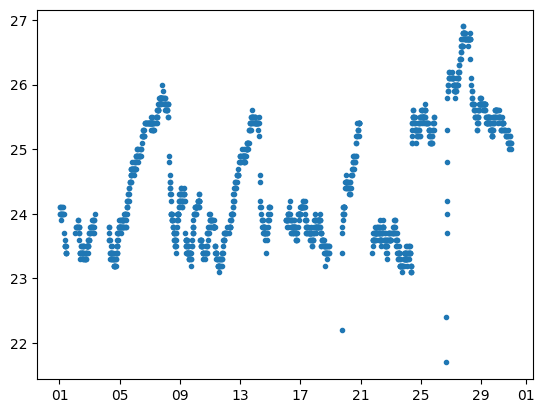

In [17]:
#to filter value_type_id and device_id
filtered_df = readings_df[(readings_df['value_type_id'] == 11) & (readings_df['device_id'] == 1)]

filtered_df.info()

start_date = '2023-8-01'
end_date = '2023-8-31'
filtered_df = filtered_df[(filtered_df['date'] >= start_date) & (filtered_df['date'] <= end_date)]

# scatter for >1 day
plt.scatter(filtered_df['date'], filtered_df['value'], marker='.')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d'))


# scatter for <1 day
# plt.scatter(filtered_df['date'].dt.hour + filtered_df['date'].dt.minute / 60, filtered_df['value'], marker='.')


plt.show



In [18]:
# Augmented Dickey-Fuller test
# determines if a series is stationary
filtered_df.info()

test_series_data = filtered_df[['value']]
test_series_data.index = pd.to_datetime(filtered_df['date'])

results = adfuller(test_series_data)

print('Test Statistic:', results[0])
print('P-Value:', results[1])


<class 'pandas.core.frame.DataFrame'>
Index: 1720 entries, 13517 to 38999838
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   device_id      1720 non-null   int64         
 1   date           1720 non-null   datetime64[ns]
 2   value_type_id  1720 non-null   int64         
 3   value          1720 non-null   float64       
 4   work_hours     1720 non-null   bool          
dtypes: bool(1), datetime64[ns](1), float64(1), int64(2)
memory usage: 68.9 KB
Test Statistic: -22.54549152601055
P-Value: 0.0
